# Ranked Plantations Stacked Barchart

Displays the Top 5 sub-regions ranked by the % of plantation cover relative to total area, containing tree plantations in a horizontal bar chart. Each bar is broken into the sub-categories (type or species).

Each bar is made up of 4 subcategories that should add to 100%.

In [1]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [2]:
# Returns json object containing admin-codes, total area and extent (both in ha)
# If adm1 is not specified, it returns the total values for each adm1 region
# Else, returns the adm2 values within that adm1 region
# You may also specify a polyname (intersecting area) e.g. 'extent and % of plantations only'
# By default polyname is 'gadm28' (all forest extent)

def multiregion_extent_queries(adm0, adm1=None, year='area_extent_2000', p_name='gadm28', threshold=30):
    if adm0 and not adm1:
        print('Request for adm1 areas')
        sql = (f"SELECT adm1 as region, sum({year}) as extent, sum(area_gadm28) as total "
               f"FROM {ds} "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}' "
               f"GROUP BY adm1 "
               f"ORDER BY adm1")
    elif adm0 and adm1:
        print('Request for adm2 areas')
        sql = (f"SELECT adm2 as region, {year} as extent, area_gadm28 as total "
                f"FROM {ds} "
                f"WHERE iso = '{adm0}' "
                f"AND thresh = {threshold} "
                f"AND polyname = '{p_name}' "
                f"AND adm1 = '{adm1}' ")
    return sql

## Ranked Plantations Stacked Barchart (by type)

Displays the Top 5 sub-regions ranked by the % of plantation cover relative to total area, containing tree plantations in a horizontal bar chart. Each bar is broken into the sub-categories (type or species).

Each bar is made up of 4 subcategories that should add to 100%.

Subcategory % calculated by dividing the extent by the total extent of plantations in the region

In [3]:
# VARIABLES

thresh = 0               # 0,10,15,20,25,30,50,75,100 
adm0 = 'BRA'
adm1 = None          
adm2 = None  

extent_year = 2000       #2000, 2010

tags = ["land_cover", "land_use"]
selectable_polynames = ['gadm28', 'plantations']

In [4]:
# Get the total extent of each region
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = multiregion_extent_queries(adm0=adm0, adm1=adm1, year=extent_year_dict[extent_year],
                                 p_name='gadm28', threshold=thresh)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
extent_total = r.json().get('data')
extent_total[0:3]

Request for adm1 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm1+as+region%2C+sum%28area_extent_2000%29+as+extent%2C+sum%28area_gadm28%29+as+total+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27gadm28%27+GROUP+BY+adm1+ORDER+BY+adm1
Status: 200


[{'extent': 14502759.1015625, 'region': 1, 'total': 15273286.984375},
 {'extent': 800115.4713287354, 'region': 2, 'total': 2775822.3068847656},
 {'extent': 12382432.1640625, 'region': 3, 'total': 14221825.859375}]

In [5]:
# Gets plantation areas by type, for each subregion
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = (f"SELECT SUM({extent_year_dict[extent_year]}) AS plantation_extent FROM {ds} WHERE iso = 'BRA' "
       f"AND thresh = 0 AND polyname = 'plantations' "
       f"GROUP BY adm1, bound1 ORDER BY plantation_extent DESC")

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
plantations_areas = r.json().get('data')
plantations_areas[0:3]

https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+AS+plantation_extent+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27plantations%27+GROUP+BY+adm1%2C+bound1+ORDER+BY+plantation_extent+DESC
Status: 200


[{'adm1': 13,
  'bound1': 'Large industrial plantation',
  'plantation_extent': 884758.8332473561},
 {'adm1': 13,
  'bound1': 'Clearing/ very young plantation',
  'plantation_extent': 134288.48072965443},
 {'adm1': 13,
  'bound1': 'Mosaic of small-sized plantations',
  'plantation_extent': 1033.8712158203125}]

In [6]:
#Formats data into a usable json object
def format_plantations_data(plantations_areas, extent_total, adm0, adm1=None, p_type='species'):
    if adm1:
        # Find out the unique list of regions in the returned array
        unique_regions = []
        for row in plantations_areas:
            #print(row)
            tmp_region = row.get('adm2', None)
            if tmp_region not in unique_regions:
                unique_regions.append(tmp_region)

        # Loop over that list of regions
        plantations_json = []
        for region in unique_regions:
            tmp_p = 0
            # gather all yearly data from the loss json object
            for row in plantations_areas:
                tmp_region = row.get('adm2', None)
                if tmp_region == region:
                    tmp_p += row.get('plantation_extent', 0)
            #get extent
            tmp_t=0
            for row in extent_total:
                if row.get('region') == region:
                    tmp_t = row.get('extent')
                    break
            # gather extent data from the extent json object
            tmp_data = []
            for row in plantations_areas:
                if row.get('adm2') == region: 
                    if p_type == 'type':
                        tmp_data.append([row.get('bound1'), row.get('plantation_extent')])
                    else:
                        tmp_data.append([row.get('bound2'), row.get('plantation_extent')])

            plantations_json.append({'region':region,
                                     'data': tmp_data,
                                     'plantations_total': tmp_p,
                                     'perc': 100*tmp_p/tmp_t,
                                     'region_total': tmp_t
                                    })

    elif adm0:

        # Find out the unique list of regions in the returned array
        unique_regions = []
        for row in plantations_areas:
            #print(row)
            tmp_region = row.get('adm1', None)
            if tmp_region not in unique_regions:
                unique_regions.append(tmp_region)

        # Loop over that list of regions
        plantations_json = []
        for region in unique_regions:
            tmp_p = 0
            # gather all yearly data from the loss json object
            for row in plantations_areas:
                tmp_region = row.get('adm1', None)
                if tmp_region == region:
                    tmp_p += row.get('plantation_extent', 0)
            #get extent
            tmp_t=0
            for row in extent_total:
                if row.get('region') == region:
                    tmp_t = row.get('extent')
                    break
            # gather extent data from the extent json object
            tmp_data = []
            for row in plantations_areas:
                if row.get('adm1') == region: 
                    if p_type == 'type':
                        tmp_data.append([row.get('bound1'), row.get('plantation_extent')])
                    else:
                        tmp_data.append([row.get('bound2'), row.get('plantation_extent')])

            plantations_json.append({'region':region,
                                     'data': tmp_data,
                                     'plantations_total': tmp_p,
                                     'perc': 100*tmp_p/tmp_t,
                                     'region_total': tmp_t
                                    })

    return plantations_json


In [7]:
plantations_json = format_plantations_data(plantations_areas, extent_total, adm0, adm1, 'type')

In [8]:
#Sort regions by % area of plantations (DESC)

sorted_list1 = sorted(plantations_json, key=lambda k: k['perc'], reverse=True) 
sorted_list1[0]

{'data': [['Large industrial plantation', 895171.1094231904],
  ['Clearing/ very young plantation', 22645.54149529338]],
 'perc': 13.018225543693056,
 'plantations_total': 917816.6509184837,
 'region': 25,
 'region_total': 7050243.8895225525}

In [9]:
#Collects data in a presentable way.
#The following code collects data into the correct groups so that a stacked bar can be implemented
# For each adm region this collects the extents by type and calaculates its percentage relative to 
# total plantation extent
lip = []
vyp = []
ssp = []
msp = []
region = []

#We want the top 5 regions by plantation cover relative to total extent
max_num = 5


for i in range(0,max_num):
    
    length = len(sorted_list1[i].get('data'))
    region.append(str(sorted_list1[i].get('region')))
    flag = 0
    
    for j in range(0,length):
        
        if sorted_list1[i].get('data')[j][0] =='Large industrial plantation':
            lip.append(100 * sorted_list1[i].get('data')[j][1] / sorted_list1[i].get('plantations_total'))
            break
        elif flag == length-1:
            lip.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list1[i].get('data')[j][0] =='Clearing/ very young plantation':
            vyp.append(100 * sorted_list1[i].get('data')[j][1] / sorted_list1[i].get('plantations_total'))
            break
        elif flag == length-1:
            vyp.append(0)
        else:
            flag += 1
    flag = 0        
    for j in range(0,length):
        
        if sorted_list1[i].get('data')[j][0] =='Mosaic of small-sized plantations':
            ssp.append(100 * sorted_list1[i].get('data')[j][1] / sorted_list1[i].get('plantations_total'))
            break
        elif flag == length-1:
            ssp.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list1[i].get('data')[j][0] =='Mosaic of medium-sized plantations':
            msp.append(100 * sorted_list1[i].get('data')[j][1] / sorted_list1[i].get('plantations_total'))
            break
        elif flag == length-1:
            msp.append(0)
        else:
            flag += 1
            

In [10]:
#create a json of data
d1 = {
    'Large industrial plantation': lip,
    'Clearing/ very young plantation': vyp,
    'Mosaic of small-sized plantations': ssp,
    'Mosaic of medium-sized plantations': msp
    
}

### Horz. Stacked Bars Details

The chart below shows the top 5 subregions ranked by extent found in plantation relative to the subregion's total area (extent of plantations / total area). We may also want to give users the ability to rank by gross extent instead (i.e. ha)

Each bar is broken down into what percentage of plantation extent is found in each of the 4 types. Since this is a percentage, all bars are the same length. 

In [11]:
#create dataframe to visualise using pandas
df1 = pd.DataFrame(data=d1)
df1

,Clearing/ very young plantation,Large industrial plantation,Mosaic of medium-sized plantations,Mosaic of small-sized plantations
0,2.467327,97.532673,0,0
1,7.332298,92.667702,0,0
2,6.973439,93.026561,0,0
3,13.693243,86.306757,0,0
4,3.530766,96.469234,0,0


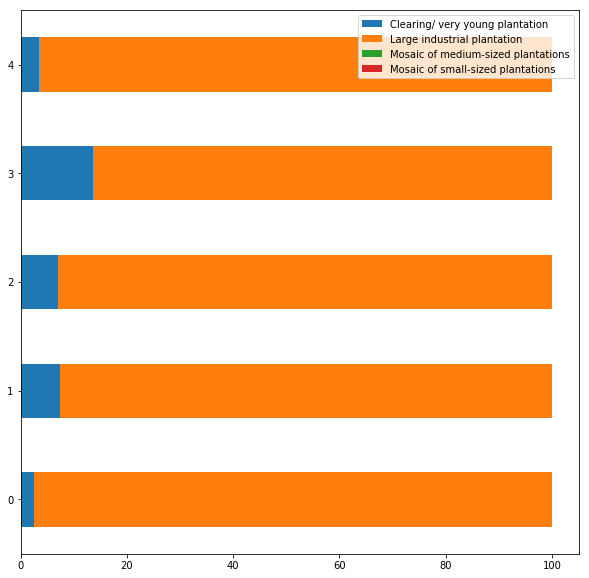

In [12]:
df1.plot.barh(stacked=True,figsize=(10,10),legend=True)

In [13]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm1:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')

tmp = get_admin1_json(iso=adm0)
adm1_to_name={}
for row in tmp:
    adm1_to_name[row.get('adm1')] = row.get('name') 

In [14]:
#Dynamic sentence (easier to use sorted_list1)

if adm1:
    print(f"{adm2_to_name[sorted_list1[0].get('region')]} ({extent_year}) has the largest ", end="")
    print(f"relative tree cover due to plantations ({sorted_list1[0].get('perc'):.1f}%) ", end="")
    print(f"in {adm1_to_name[adm1]} ({extent_year}), ", end="")
elif adm0: 
    print(f"{adm1_to_name[sorted_list1[0].get('region')]} ({extent_year}) has the largest ", end="")
    print(f"relative tree cover due to plantations ({sorted_list1[0].get('perc'):.1f}%) ", end="")
    print(f"in {iso_to_countries[adm0]}, ", end="")


print(f"most of which is {plantation_type_dict[sorted_list1[0].get('data')[0][0]]} plantations ", end="")
print(f"where tree canopy is greater than {thresh}%.", end="")

Santa Catarina (2000) has the largest relative tree cover due to plantations (13.0%) in Brazil, most of which is large industrial plantations where tree canopy is greater than 0%.

## Ranked Plantations Stacked Barchart (by species)

Displays the Top 5 sub-regions ranked by the % of plantation cover relative to total area, containing tree plantations in a horizontal bar chart. Each bar is broken into the sub-categories (type or species).

Each bar is made up of 4 subcategories that should add to 100%.

Subcategory % calculated by dividing the extent by the total extent of plantations in the region

In [15]:
# VARIABLES

thresh = 0               # 0,10,15,20,25,30,50,75,100 
adm0 = 'BRA'
adm1 = None          
adm2 = None            

extent_year = 2000        #2000 or 2010

tags = ["land_cover", "land_use"]
selectable_polynames = ['gadm28', 'plantations']

In [16]:
# Get the total extent of each region
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = multiregion_extent_queries(adm0=adm0, adm1=adm1, p_name='gadm28',
                                 year=extent_year_dict[extent_year], threshold=thresh)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
extent_total = r.json().get('data')
extent_total[0:3]

Request for adm1 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm1+as+region%2C+sum%28area_extent_2000%29+as+extent%2C+sum%28area_gadm28%29+as+total+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27gadm28%27+GROUP+BY+adm1+ORDER+BY+adm1
Status: 200


[{'extent': 14502759.1015625, 'region': 1, 'total': 15273286.984375},
 {'extent': 800115.4713287354, 'region': 2, 'total': 2775822.3068847656},
 {'extent': 12382432.1640625, 'region': 3, 'total': 14221825.859375}]

In [17]:
# Gets plantation areas by species, for each subregion
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = (f"SELECT SUM({extent_year_dict[extent_year]}) AS plantation_extent FROM {ds} WHERE iso = 'BRA' "
       f"AND thresh = 0 AND polyname = 'plantations' "
       f"GROUP BY adm1, bound2 ORDER BY plantation_extent DESC")

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
plantations_areas = r.json().get('data')
plantations_areas[0:3]

https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+AS+plantation_extent+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27plantations%27+GROUP+BY+adm1%2C+bound2+ORDER+BY+plantation_extent+DESC
Status: 200


[{'adm1': 13,
  'bound2': 'Wood fiber / timber',
  'plantation_extent': 866630.5609202683},
 {'adm1': 13,
  'bound2': 'Recently cleared',
  'plantation_extent': 134288.48072965443},
 {'adm1': 13, 'bound2': 'Fruit', 'plantation_extent': 12757.236675739288}]

In [18]:
#apply function to create json
plantations_json = format_plantations_data(plantations_areas, extent_total, adm0, adm1, 'species')

In [19]:
#Sort regions by % area of plantations (DESC)

sorted_list = sorted(plantations_json, key=lambda k: k['perc'], reverse=True) 
sorted_list[0]

{'data': [['Wood fiber / timber', 895171.1094231904],
  ['Recently cleared', 22645.54149529338]],
 'perc': 13.018225543693056,
 'plantations_total': 917816.6509184837,
 'region': 25,
 'region_total': 7050243.8895225525}

In [20]:
#The following code collects data into the correct groups so that a stacked bar can be implemented
# For each adm region this collects the extents by type and calaculates its percentage relative to 
# total plantation extent

wft = []
wfm = []
rc = []
unk = []
frt = []
frm = []
opt = []
oth = []
otm = []
rub = []

region = []
#we only want the top X to be displayed
max_num = 5


for i in range(0,max_num):
    
    length = len(sorted_list[i].get('data'))
    region.append(str(sorted_list[i].get('region')))
    flag = 0
    
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Wood fiber / timber':
            wft.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            wft.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Wood fiber / timber mix':
            wfm.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            wfm.append(0)
        else:
            flag += 1
    flag = 0        
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Recently cleared':
            rc.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            rc.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Unknown':
            unk.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            unk.append(0)
        else:
            flag += 1
    flag = 0        
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Fruit':
            frt.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            frt.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Fruit mix':
            frm.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            frm.append(0)
        else:
            flag += 1
    flag = 0        
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Oil palm':
            opt.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            opt.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Other mix':
            otm.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            otm.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Other':
            oth.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            oth.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Rubber':
            rub.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            rub.append(0)
        else:
            flag += 1
            

In [21]:
#Prepare data to be visualised with pandas
d = {
    'Wood Fiber and Timber': wft,
    'Wood Fibre and Timber mix': wfm,
    'Recently Cleared': rc,
    'Unknown': unk,
    'Fruit Trees': frt,
    'Fruit Tree mix': frm,
    'Oil Palm': opt,
    'Other mix': otm,
    'Other': oth,
    'Rubber Trees': rub
    
}

In [22]:
#Creates dataframe to visualise data
df = pd.DataFrame(data=d)
df

,Fruit Tree mix,Fruit Trees,Oil Palm,Other,Other mix,Recently Cleared,Rubber Trees,Unknown,Wood Fiber and Timber,Wood Fibre and Timber mix
0,0,0.000000,0,0,0.000000,2.467327,0.000000,0.000000,97.532673,0
1,0,0.068368,0,0,0.000000,7.332298,0.000000,0.146110,92.453224,0
2,0,0.579796,0,0,6.746915,6.973439,1.498479,0.041432,84.159938,0
3,0,0.000000,0,0,0.000000,13.693243,0.000000,0.000000,86.306757,0
4,0,0.000000,0,0,0.000000,3.530766,0.000000,0.184963,96.284270,0


### Horz. Stacked Bars Details

The chart below shows the top 5 subregions ranked by extent found in plantation relative to the subregion's total area (extent of plantations / total area). We may also want to give users the ability to rank by gross extent instead (i.e. ha)

Each bar is broken down into what percentage of plantation extent is found in each of the species. Since this is a percentage, all bars are the same length. 

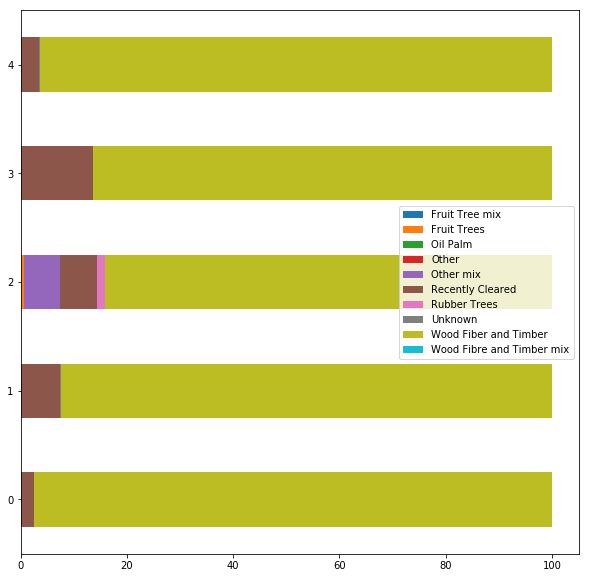

In [23]:
df.plot.barh(stacked=True,figsize=(10,10),legend=True)

In [24]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm1:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')

tmp = get_admin1_json(iso=adm0)
adm1_to_name={}
for row in tmp:
    adm1_to_name[row.get('adm1')] = row.get('name') 

In [33]:
#Dynamic sentence (easier to use sorted list)

if adm1:
    print(f"Within {adm1_to_name[adm1]}, {adm2_to_name[sorted_list[0].get('region')]} has the largest ", end="")
    print(f"relative area of plantation tree cover extent in {extent_year} ", end="")
    print(f"at {sorted_list[0].get('perc'):.1f}%, ", end="")
elif adm0: 
    print(f"Within {iso_to_countries[adm0]}, {adm1_to_name[sorted_list[0].get('region')]} has the largest ", end="")
    print(f"relative area of plantation tree cover in {extent_year} ", end="")
    print(f"at {sorted_list[0].get('perc'):.1f}%, ", end="")

print(f"where tree canopy is greater than {thresh}%. ", end="")
print(f"The majority of this area is used for {plantation_species_dict[sorted_list[0].get('data')[0][0]]} ", end="")


Within Brazil, Santa Catarina has the largest relative area of plantation tree cover in 2000 at 13.0%, where tree canopy is greater than 0%. The majority of this area is used for wood fiber and timber 